In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from os import path


plt.rcParams['savefig.dpi'] = 200

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 20, 12
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

plt.rcParams['text.usetex'] = False # True activates latex output in fonts!
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = "\usepackage{subdepth}, \usepackage{type1cm}"

In [2]:
CSV_FILE_PATH = path.join(path.pardir, "data", "preprocessed", "voting.csv")
df = pd.read_csv(CSV_FILE_PATH)

In [3]:
print("%d many entries" % df.size)

51048 many entries


In [4]:
df.head(10)

,Abstimmnr,Fraktion/Gruppe,Bezeichnung,vote,Fraktion,source
0,3.0,CDU/CSU,Dr. Michael von Abercron,1.0,2,data/raw_csv/20171213_3_xls-data
1,3.0,CDU/CSU,Stephan Albani,1.0,2,data/raw_csv/20171213_3_xls-data
2,3.0,CDU/CSU,Norbert Maria Altenkamp,1.0,2,data/raw_csv/20171213_3_xls-data
3,3.0,CDU/CSU,Peter Altmaier,1.0,2,data/raw_csv/20171213_3_xls-data
4,3.0,CDU/CSU,Philipp Amthor,1.0,2,data/raw_csv/20171213_3_xls-data
5,3.0,CDU/CSU,Artur Auernhammer,1.0,2,data/raw_csv/20171213_3_xls-data
6,3.0,CDU/CSU,Peter Aumer,1.0,2,data/raw_csv/20171213_3_xls-data
7,3.0,CDU/CSU,Dorothee Bär,1.0,2,data/raw_csv/20171213_3_xls-data
8,3.0,CDU/CSU,Thomas Bareiß,1.0,2,data/raw_csv/20171213_3_xls-data
9,3.0,CDU/CSU,Norbert Barthle,1.0,2,data/raw_csv/20171213_3_xls-data


Some candidate names are duplicated.

In [5]:
CANONICAL_CANDIDATE_NAMES = {
    "Albrecht Heinz Erhard Glaser": "Albrecht Glaser",
    "Joana Eleonora Cotar": "Joana Cotar",
    "Johannes Vogel (L\xc3\xbcdenscheid)": "Johannes Vogel",
    "Johannes Vogel (Olpe)": "Johannes Vogel",
    "Konstantin Elias Kuhle": "Konstantin Kuhle"
}

df.replace(to_replace=CANONICAL_CANDIDATE_NAMES, inplace=True)

In [6]:
X = []
y = []
names = []

for name, data in df.groupby("Bezeichnung"):
    X.append(np.array(data["vote"].values))
    y.append(data["Fraktion"].unique()[0]) # HACK
    names.append(name)

In [7]:
X, y = X, np.array(y)

Check for candidates where we do not have all votes

In [8]:
n_max_votes = max(len(x) for x in X)
incomplete_names = [names[i] for i, x in enumerate(X) if len(x) < n_max_votes]
incomplete_names

[]

In [9]:
all(len(x) == len(X[0]) for x in X)

True

In [10]:
X = np.array(X)
X.shape

(709, 12)

## Embed data

In [11]:
import seaborn as sns
sns.set_style("ticks")

In [12]:
from sklearn.decomposition import PCA

pca = PCA(2, random_state=1)
X_2d = pca.fit_transform(X)

pca.explained_variance_ratio_

array([ 0.63276384,  0.1775181 ])

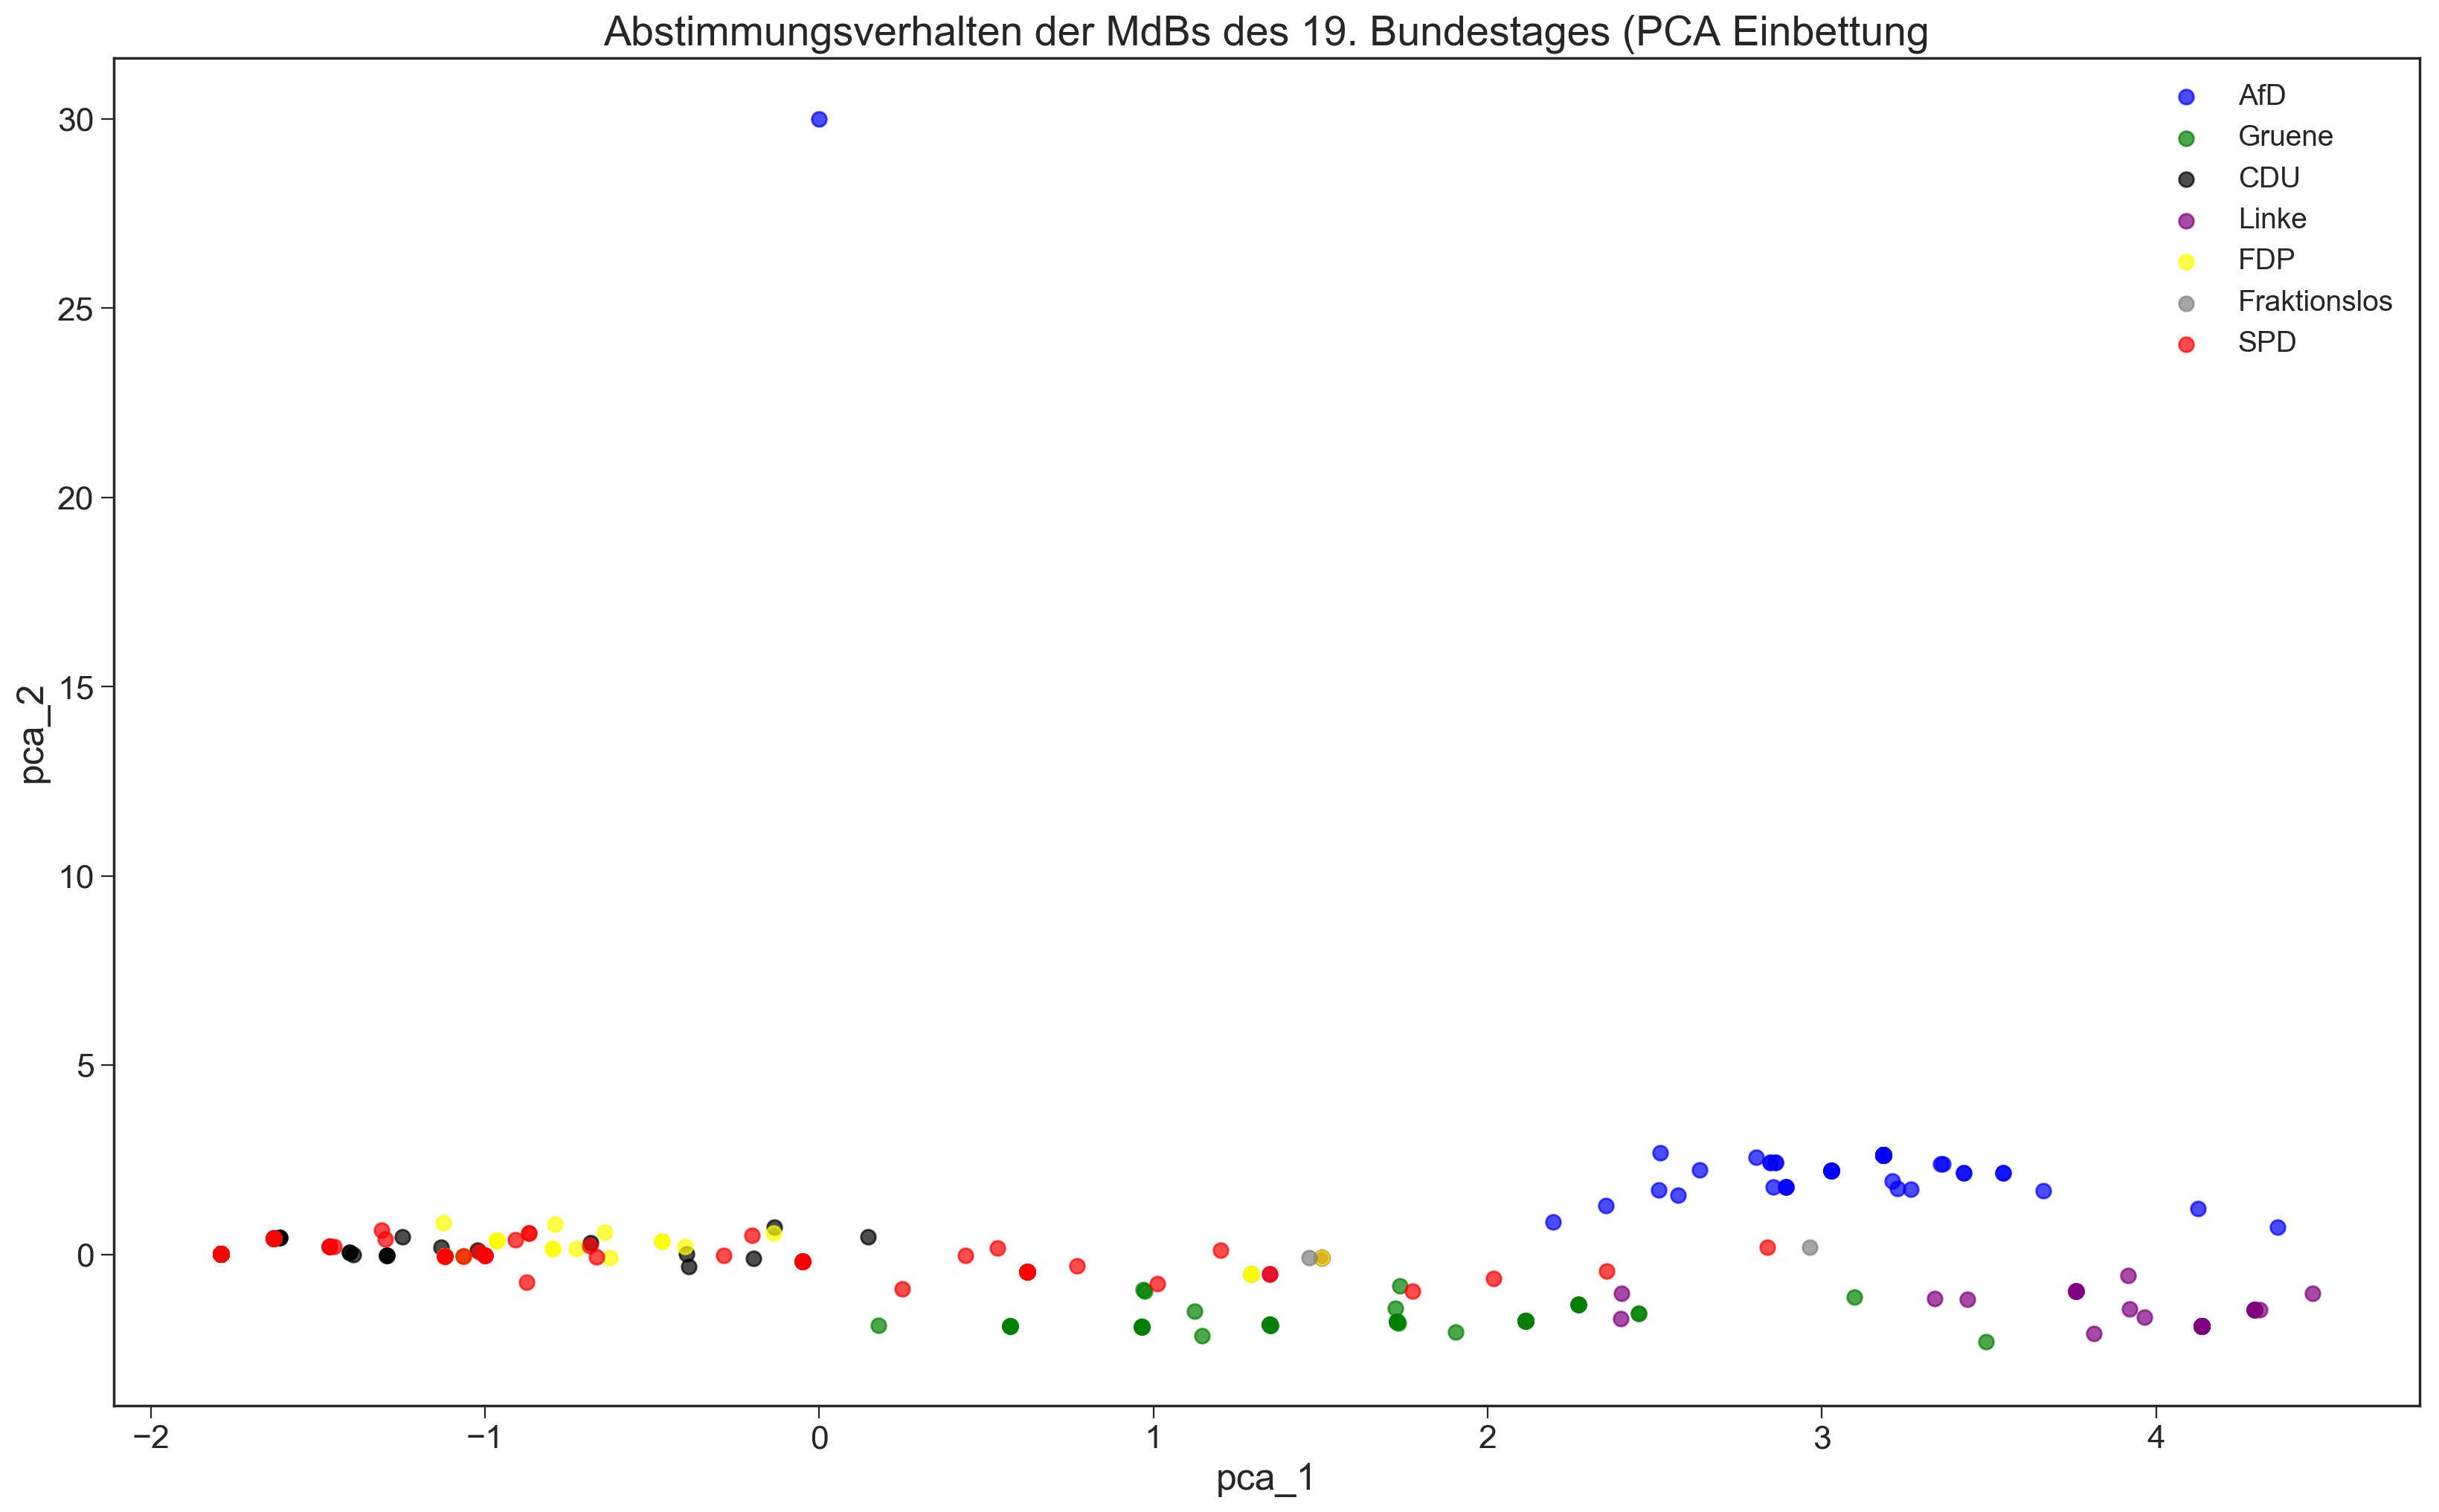

In [13]:
legends = ["AfD", "Gruene", "CDU", "Linke", "FDP", "Fraktionslos", "SPD"]
colors = ["blue", "green", "black", "purple", "yellow", "grey", "red"]

fig, ax = plt.subplots()

X_2d[680] = (0, 30)
for i, (label, color) in enumerate(zip(legends, colors)): 
    X_class = X_2d[y == i]
    ax.scatter(x=X_class[:, 0], y=X_class[:, 1], s=50, alpha=0.7, c=color, label=label)

plt.title("Abstimmungsverhalten der MdBs des 19. Bundestages (PCA Einbettung)")
plt.xlabel("pca_1")
plt.ylabel("pca_2")
plt.legend()

As can be seen 

In [14]:
from sklearn.manifold import TSNE

In [15]:
tsne = TSNE(2, n_iter=3000, random_state=1)
X_2d = tsne.fit_transform(X)

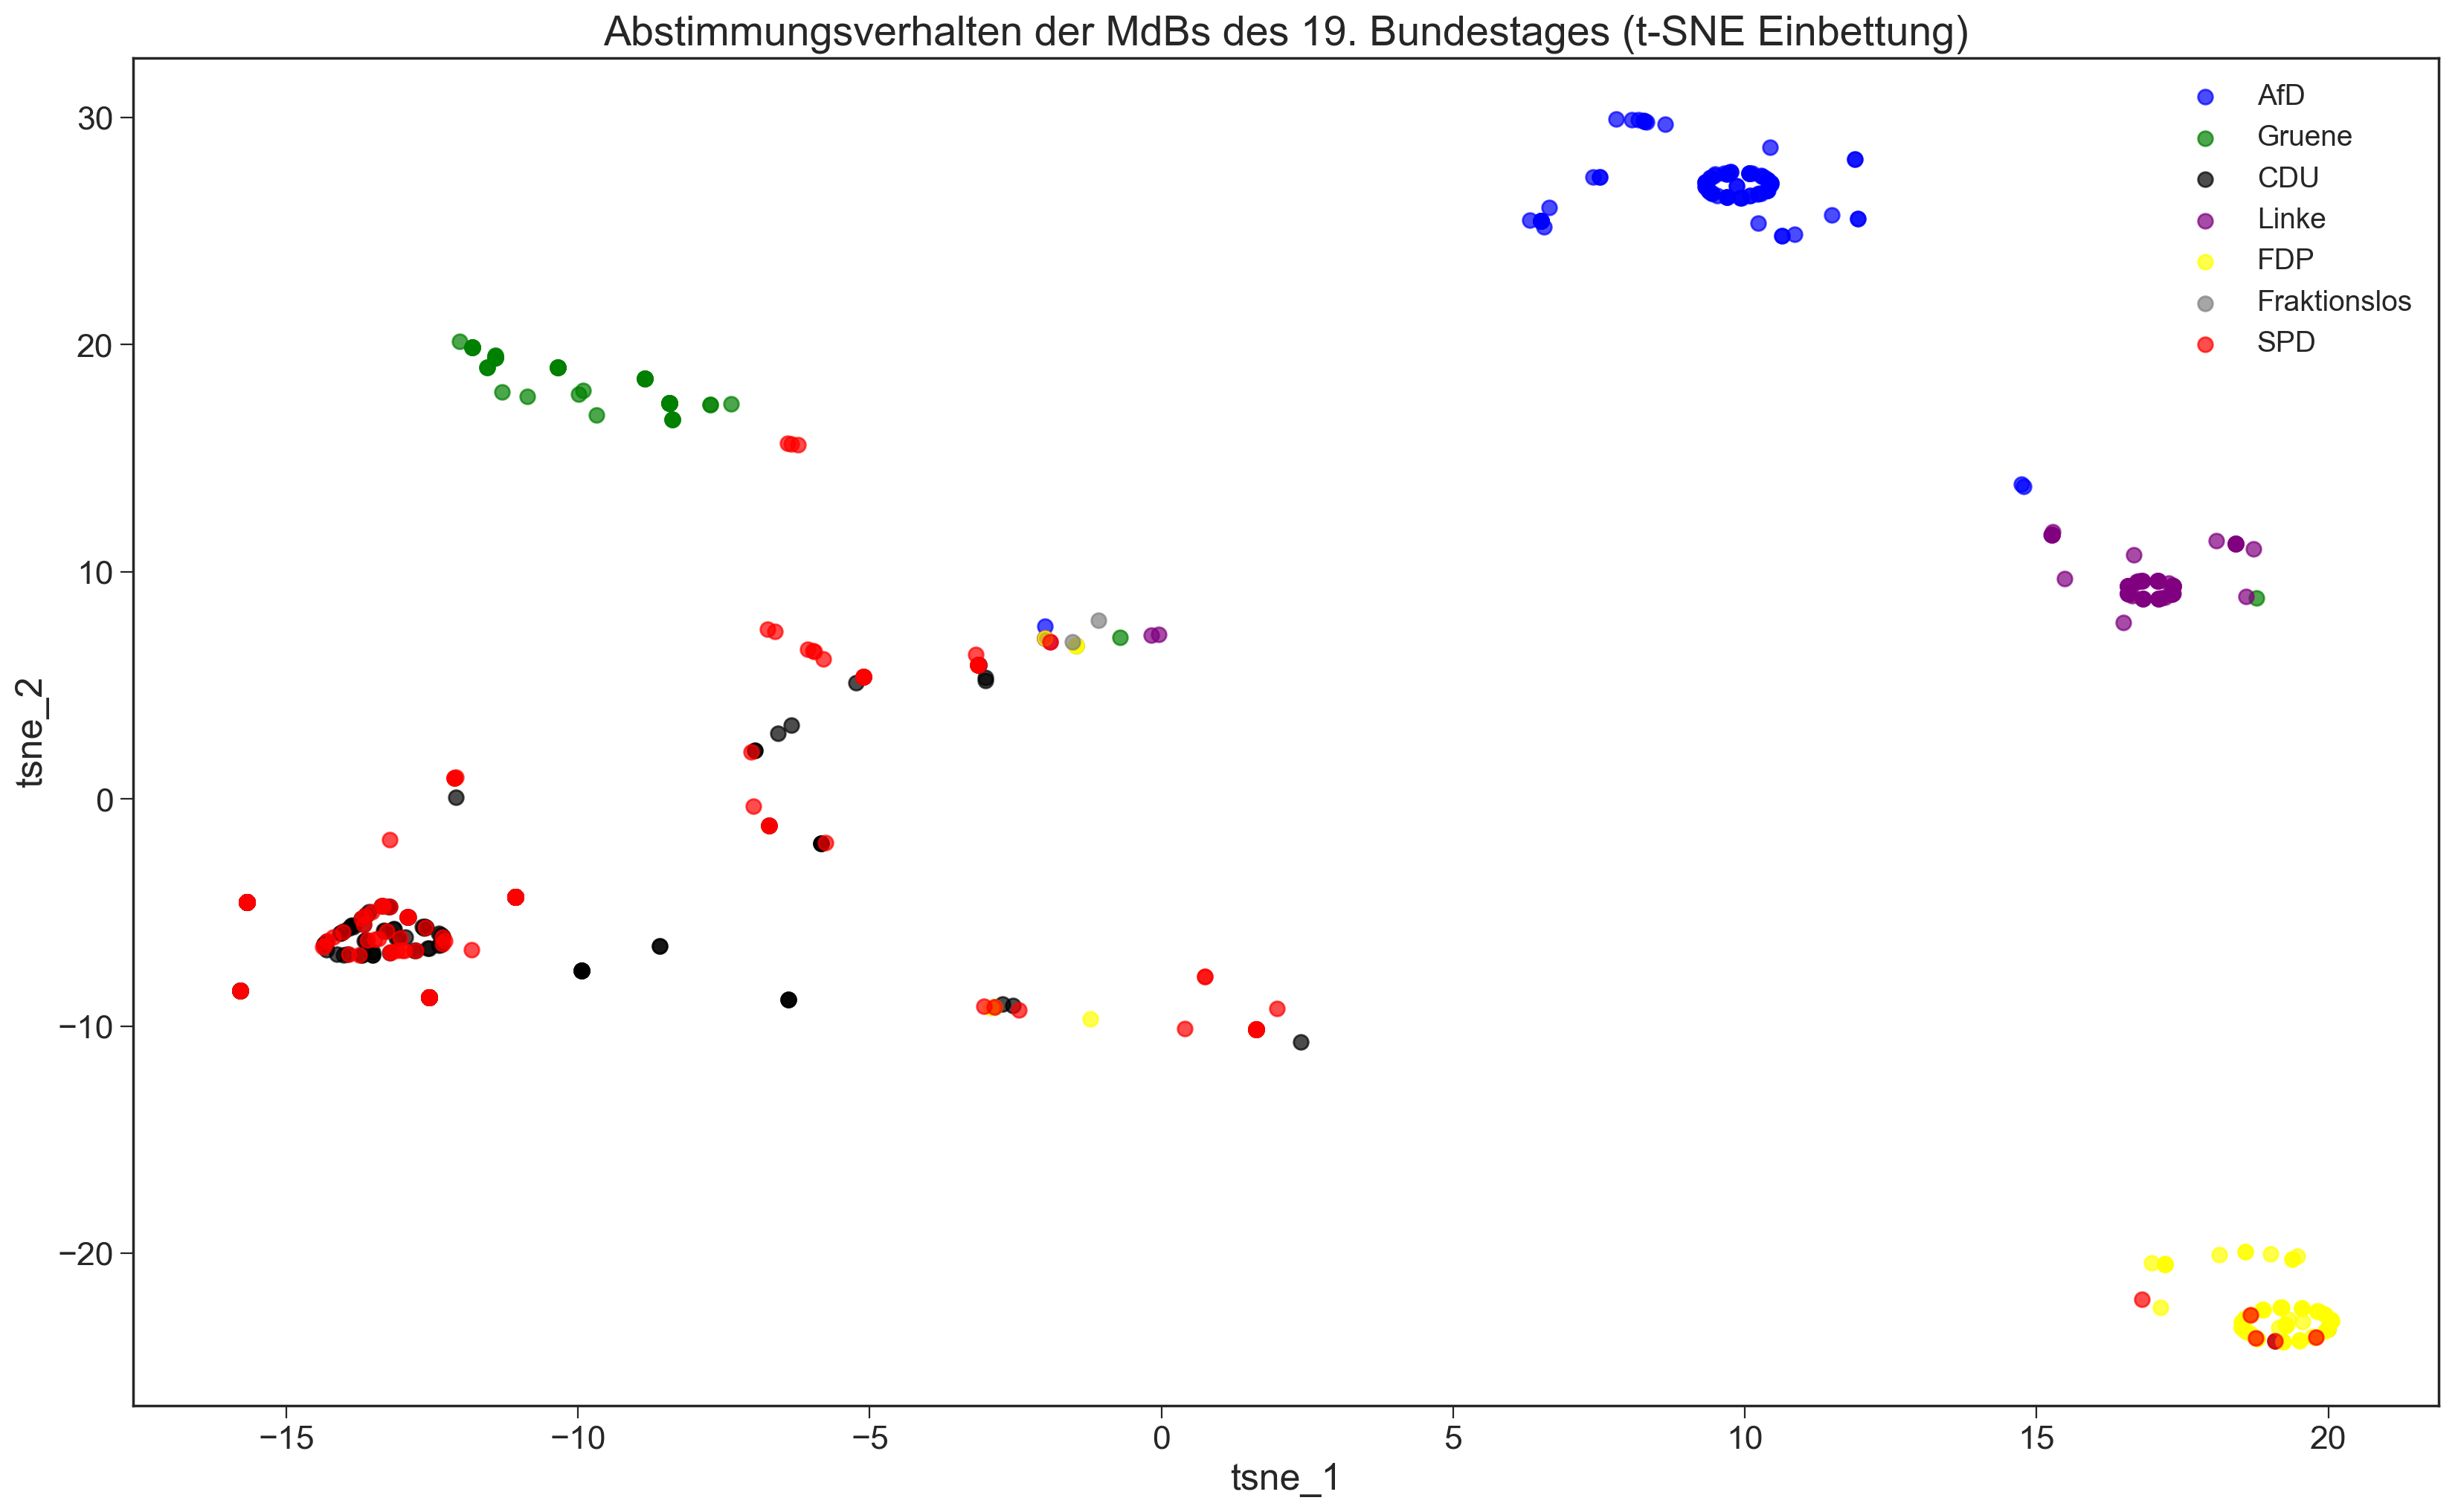

In [16]:

# 0 == AfD
# 1 == Grüne
# 2 == CDU
# 3 == Linke
# 4 == FDP
# 5 == Fraktionslos
# 6 == SPD

legends = ["AfD", "Gruene", "CDU", "Linke", "FDP", "Fraktionslos", "SPD"]
colors = ["blue", "green", "black", "purple", "yellow", "grey", "red"]

fig, ax = plt.subplots()

for i, (label, color) in enumerate(zip(legends, colors)): 
    X_class = X_2d[y == i]
    ax.scatter(x=X_class[:, 0], y=X_class[:, 1], s=50, alpha=0.7, c=color, label=label)

plt.title("Abstimmungsverhalten der MdBs des 19. Bundestages (t-SNE Einbettung)")
plt.xlabel("tsne_1")
plt.ylabel("tsne_2")
plt.legend()

There is a clear outlier for the Alternative...

### Verrätersuche 

In [17]:
X_afd = X_2d[y == 0]

In [18]:
mu_afd = X_afd.mean(axis=0)
outlier = max(X_afd, key=lambda v: np.linalg.norm(v - mu_afd))

In [19]:
np.where(X_2d == outlier)

(array([680, 680]), array([0, 1]))

In [20]:
names[680]

'Ulrich Oehme'

### Entropieanalyse

We are now trying to quantify for each faction in the Bundestag on how much disorder there is among its members. For each vote we look at the distribution of votes for each of them and calculate the entropy. Then, we take the average of the entropies over all votes and use this quantity for the comparative analysis.

$$ H(p_1, ..., p_N) = - \sum_{n=1}^N{p_n \log(p_n)}. $$

In [56]:
legends = ["AfD", "Gruene", "CDU", "Linke", "FDP", "Fraktionslos", "SPD"]

# computes entropy per column


def compute_entropy(X):
    def f(x_col):
        _, counts = np.unique(x_col, return_counts=True)
        p = counts / float(sum(counts))
        p[p == 0] = 1
        return -np.sum(p * np.log(p))

    return np.apply_along_axis(f, 0, X)

In [57]:
entropies_mean = []
entropies_std = []

for i, _ in enumerate(legends):
    entropies = compute_entropy(X[y == i])
    entropies_mean.append(np.mean(entropies))
    entropies_std.append(np.std(entropies))

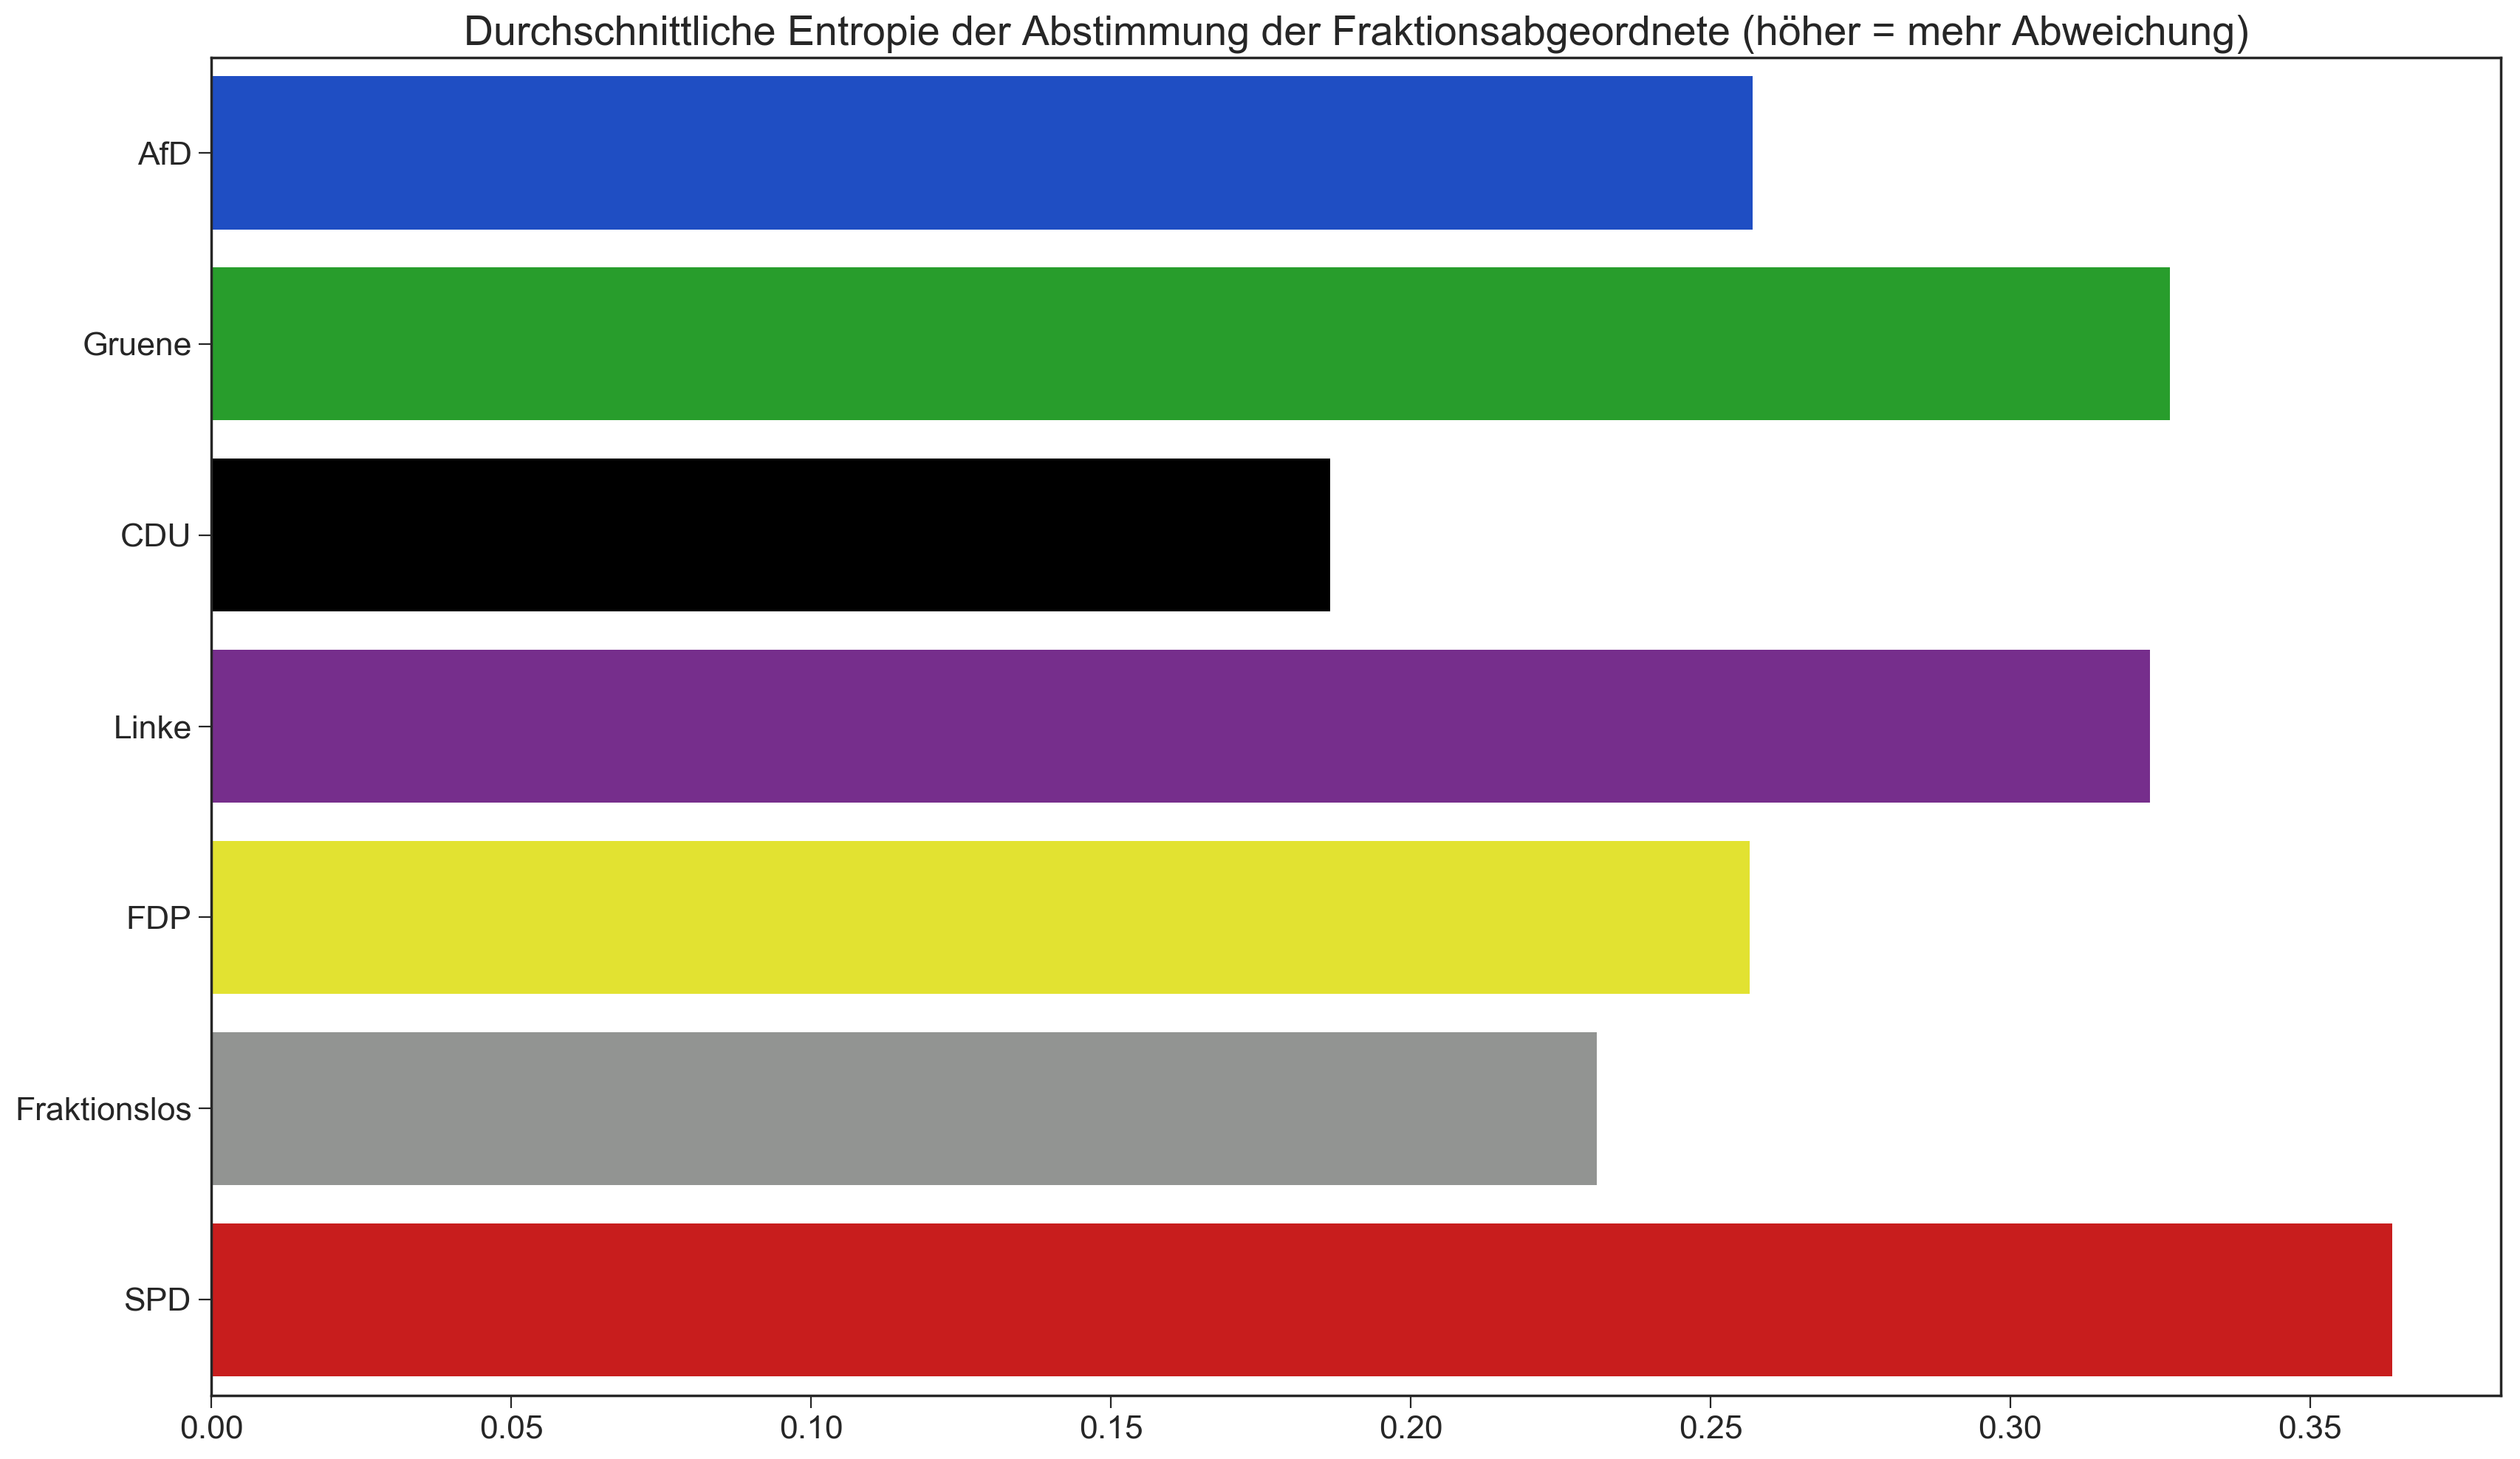

In [65]:
import seaborn as sns

sns.barplot(x=entropies_mean, y=legends, palette=sns.xkcd_palette(colors))
plt.title(u"Durchschnittliche Entropie der Abstimmung der Fraktionsabgeordnete (höher = mehr Abweichung)")

The average entropy will range between $0$ and $\log_2(\frac{1}{3}) \approx -1.5849625$. The lower it is, the less „Abweichler“ (people who voted differently existed). In the case of the max it would mean: a third each voted for "yes", "no", "N/A".

It can be seen here that the CDU is the one with the biggest „Fraktionszwang“ (i.e. parliamentarians voting as a bloc).